# PHQ-9 Depression Clustering

## Motivation

- To detect factors strongly related to the diagnosis of depressive conditions.
- To aid in the outpatient screening process for potentially depressed patients.
- To assist in the development of personalized treatment plans for patients diagnosed with depression.

## Additional information about the PHQ-9

The [Patient Health Questionnaire-9 (PHQ-9)](https://www.mdcalc.com/calc/1725/phq9-patient-health-questionnaire9#next-steps) is a widely used tool for screening and assessing the severity of depression in patients. It consists of nine questions that ask about the presence and severity of common symptoms of depression, such as feelings of sadness or hopelessness, loss of interest in activities, sleep disturbance, changes in appetite or weight, fatigue, and difficulty concentrating.

Each question is scored from 0 to 3, with a total possible score of 27:

- 0 - 4 (Minimal or none): Monitoring, may not require treatment
- 5 - 9 (Mild): Use clinical judgment (duration of symptoms, functional impairment)
- 10 - 14 (Moderate): Same as mild
- 15 - 19 (Moderately severe): Active treatment with psychotherapy, medication, or combination is warranted
- 20 - 27 (Severe): Same as moderately severe

# Importing libraries

In [6]:
pip install yellowbrick

  Using cached yellowbrick-1.5-py3-none-any.whl.metadata (7.7 kB)
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/282.6 kB ? eta -:--:--
   -

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:
plt.style.use('ggplot')
np.random.seed(42)

# Overview of data organization

In [ ]:
df = pd.read_csv("Desktop/project phase-1/phq-9-depression-assessment/Dataset_14-day_AA_depression_symptoms_mood_and_PHQ-9.csv", index_col = 0)
df.head()

In [66]:
df.shape

(16150, 35)

In [67]:
null_counts = df.isnull().sum()

fig = go.Figure()
fig.add_trace(go.Bar(x=null_counts.index, y=null_counts.values, marker_color='teal'))

fig.update_layout(title='Number of NaN values per column', xaxis_title='Column', yaxis_title='Number of NaN values', xaxis_tickangle=-45)

fig.show()

Ambulatory assessment (AA) refers to medical evaluations conducted outside of a hospital or clinical environment (q1-q4, q16, q46 and q47 instances). These evaluations are performed in an environment where the patient is free to carry out their daily activities, that is, they have not been admitted. In this study, AA was conducted using the "Moodpath" app. However, there was a significant amount of missing data over time, possibly due to patients being too sad or simply ignoring the app's reminders to answer the questions, as many of us do. It appears that the app has since been renamed "MindDoc: Your Companion" and now frequently prompts users to respond to the assessment questions every day.

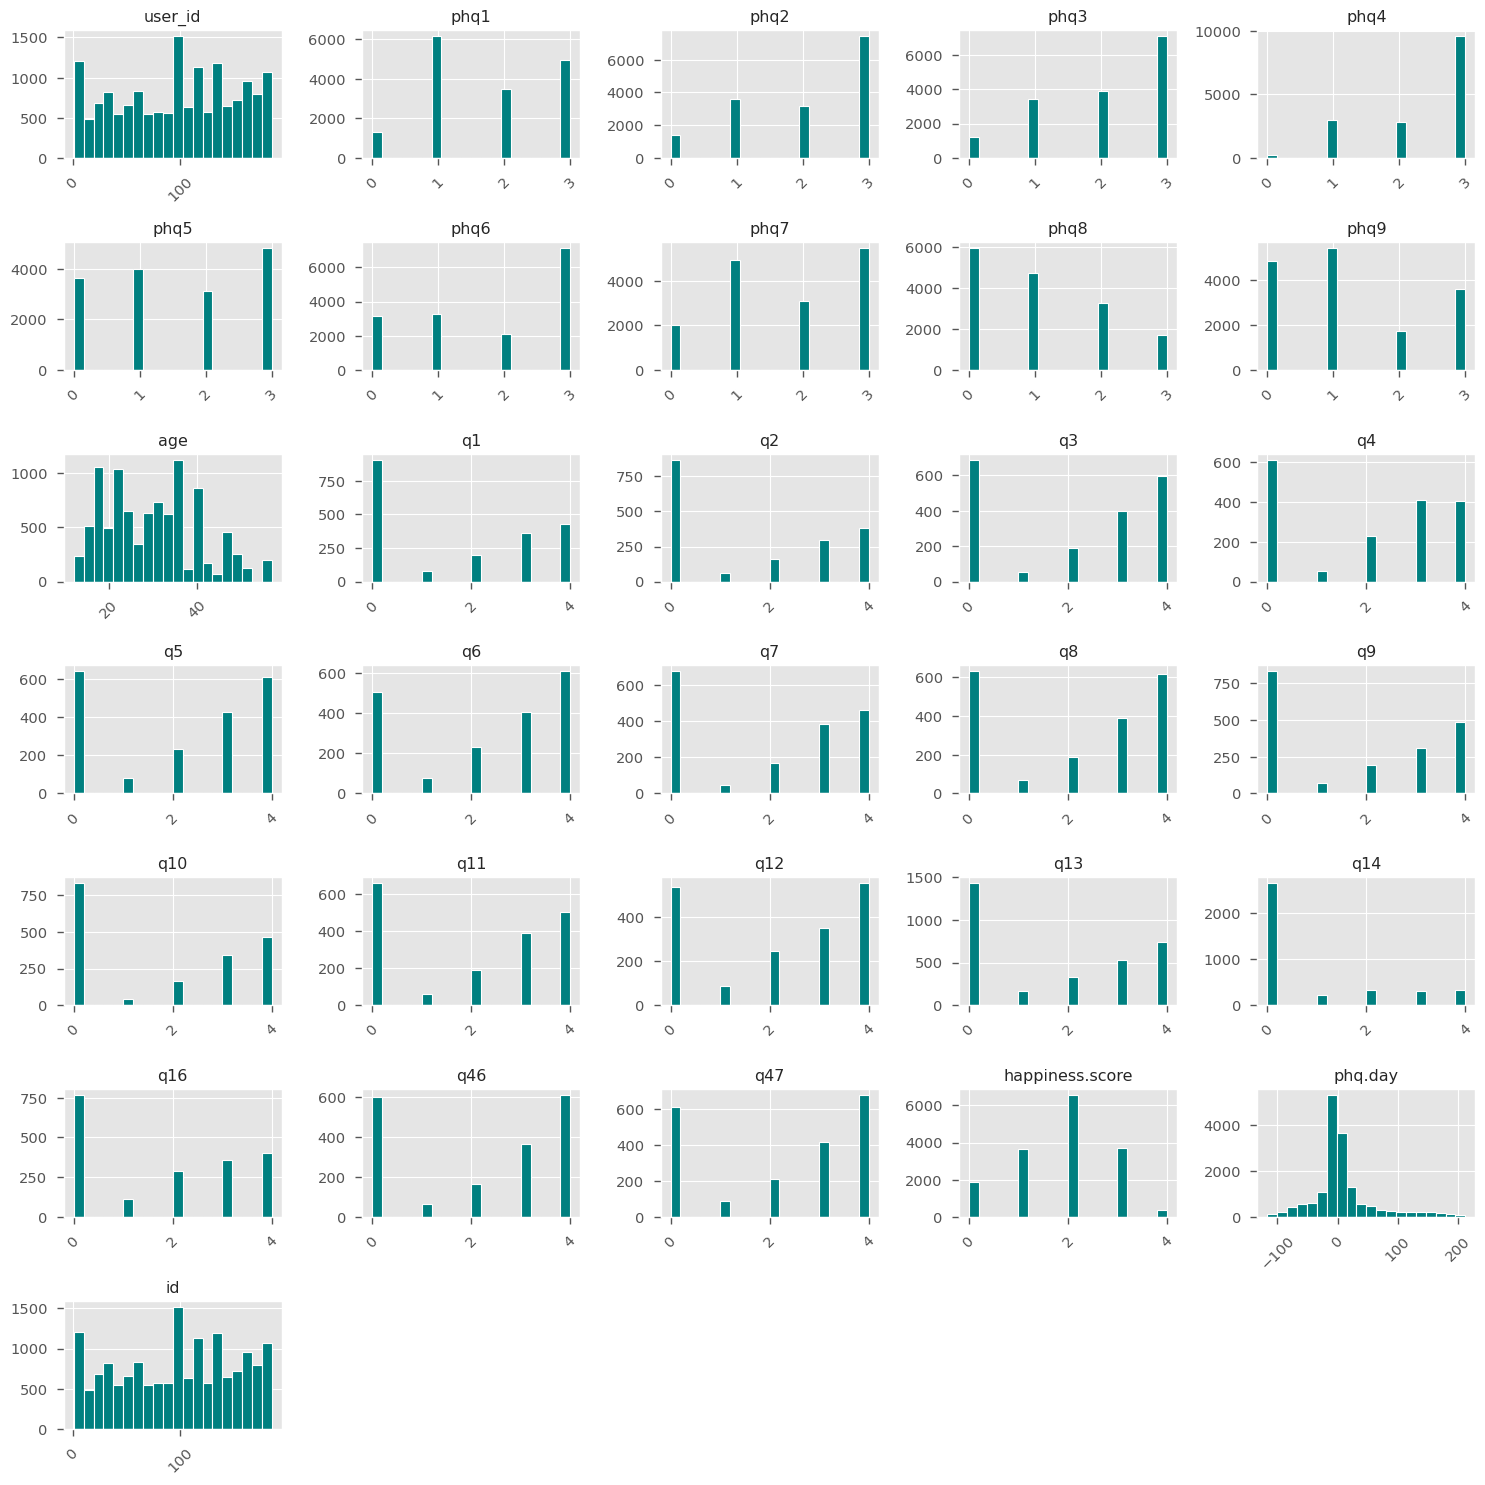

<Figure size 800x550 with 0 Axes>

In [68]:
sns.set_context(context = 'paper', font_scale= 1.2)

axes = df.hist(bins = 20, figsize = (15,15), color = 'teal', edgecolor = 'white',  
               layout=(7,5))

for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('testplot1.png')

Looking at these histograms, we noticed the following:

- The `user_id` and `id` columns are identical, so we can drop one of them.
- The`phq.day` column apparently has negative values, which needs to be further understood, given that Kaggle reports that this column represents the total number of days elapsed since the beginning of the clinical trial at the start of the assessment period.
- Many patients answered the same questionnaire multiple times. We can group each one by id.
- These attributes differ mainly in integer and date values, so we need to handle the dimensionality of these values, including categorical ones.

Let's compare the difference between `time` and `start.time`, and take the absolute value of `phq.day`:

In [69]:
# Converting the "time" column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Converting the "start.time" column to a datetime object
df['start.time'] = pd.to_datetime(df['start.time'])

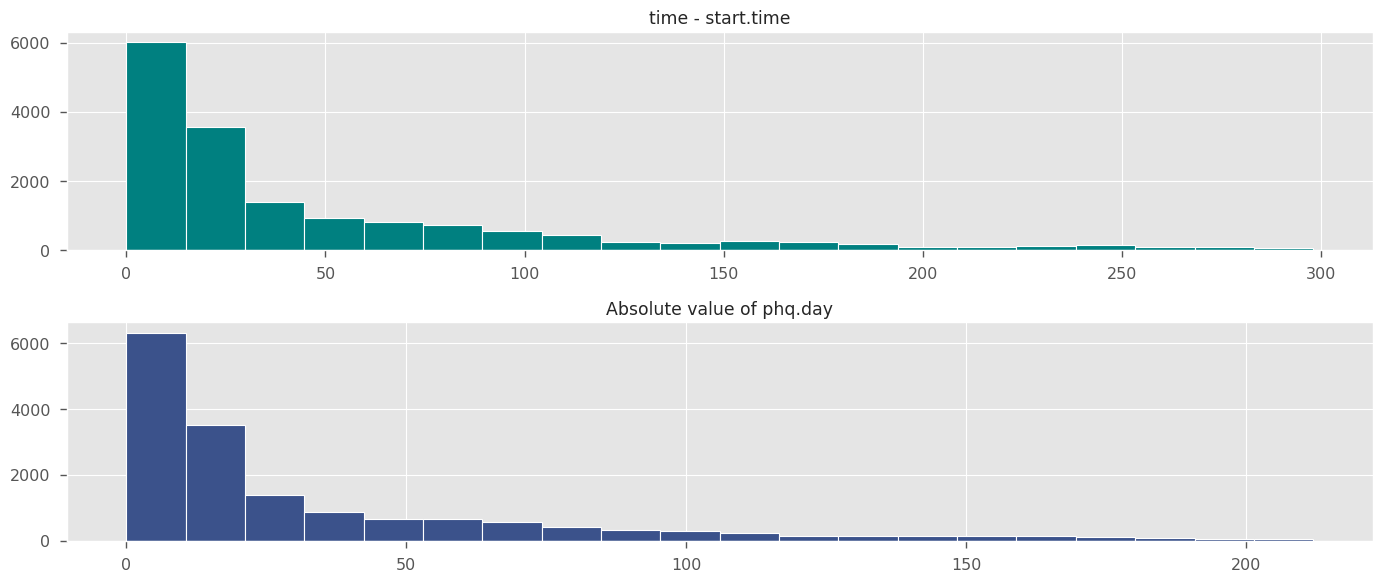

<Figure size 800x550 with 0 Axes>

In [70]:
sns.set_context(context = 'paper', font_scale= 1.3)

plt.subplot(2,1,1)
(df['time'] - df['start.time']).dt.days.hist(bins = 20, color = 'teal', 
                                             edgecolor = 'white',
                                            figsize = (14,6))
plt.title('time - start.time')

plt.subplot(2,1,2)
plt.title('Absolute value of phq.day')
df['phq.day'].abs().hist(bins = 20, color = '#3b528b', edgecolor = 'white',
                                            figsize = (14,6))

plt.tight_layout()
plt.show()
plt.savefig('testplot2.png')

It seems that the `phq.day` column does indeed represent the interval values in which the clinical trials occurred, but it is unclear why there are negative values.

# Exploratory Data Analysis

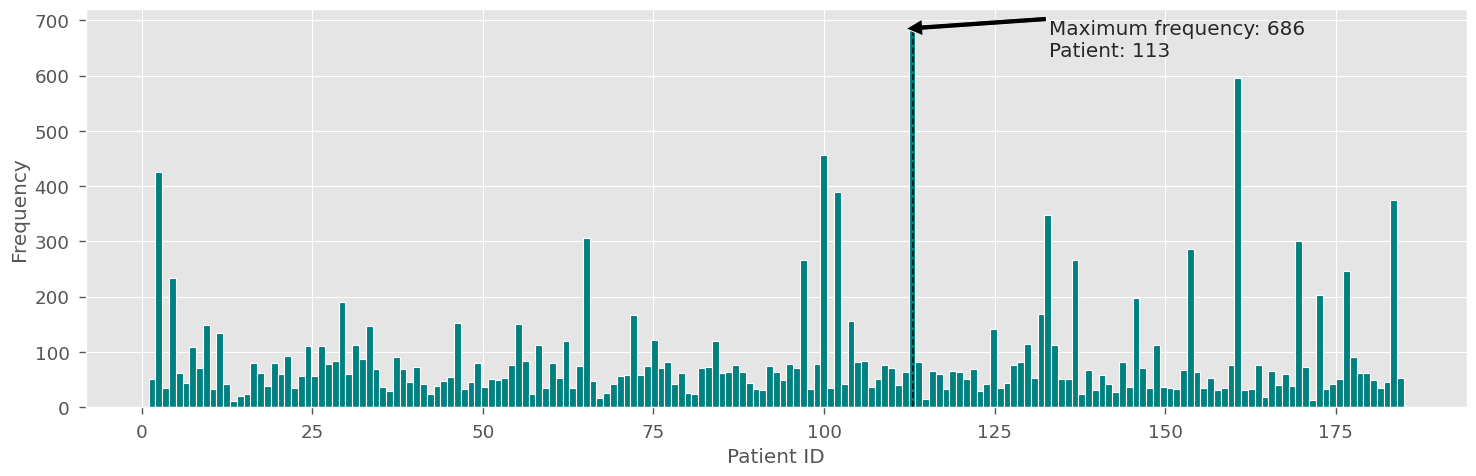

<Figure size 800x550 with 0 Axes>

In [71]:
plt.figure(figsize = (15,5))
sns.set_context(context = 'paper', font_scale= 1.5)

plt.hist(df['id'], bins= df['id'].nunique(), color = 'teal', edgecolor = 'white')

freq_max = df['id'].value_counts().max()

bin_freq_max = df['id'].value_counts().idxmax()

plt.vlines(x=bin_freq_max, ymin=0, ymax=freq_max, color='k', linestyle='--')

plt.annotate(f'Maximum frequency: {freq_max} \nPatient: {bin_freq_max}', 
             xy=(bin_freq_max - 1, freq_max - 1), 
             xytext=(bin_freq_max + 20, freq_max - 50),
             arrowprops=dict(facecolor='black'))

plt.xlabel('Patient ID')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
plt.savefig('testplot3.png')

The figure above shows that the patients took the test multiple times, where patient ID 113 retook it 686 times. Let's see the evolution of this patient's happiness.score over time.

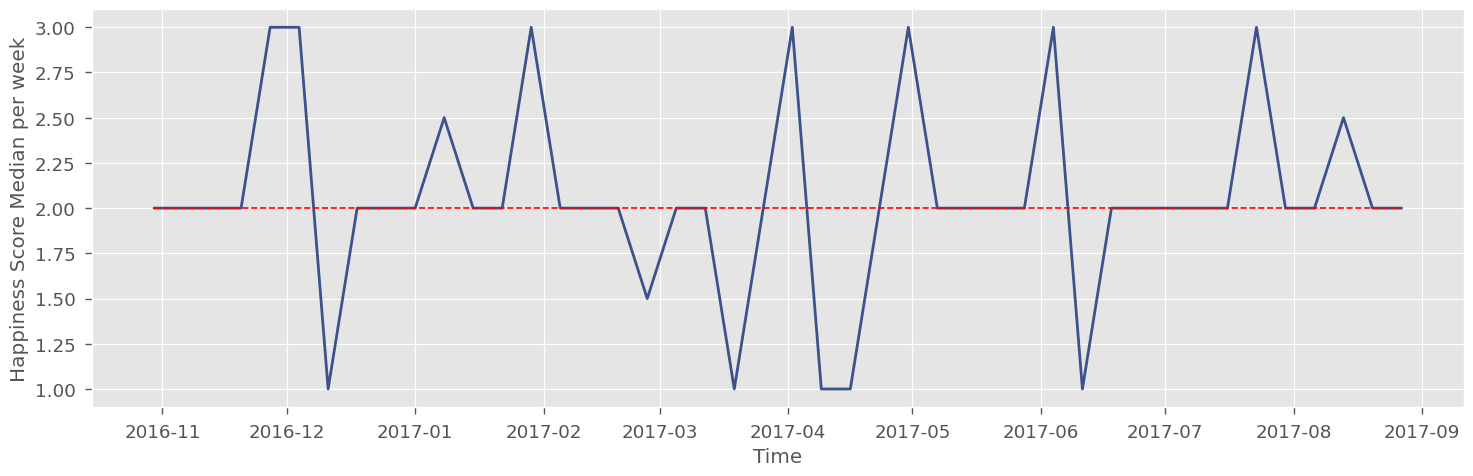

<Figure size 800x550 with 0 Axes>

In [72]:
# Data from patient 113 grouped by week with the median of each group
patiente_113 = df[df['id'] == bin_freq_max].groupby(pd.Grouper(key='time', 
                                                               freq='W')).median()

plt.figure(figsize=(15, 5))
plt.plot(patiente_113.index, patiente_113['happiness.score'], lw=2, 
         color = '#3b528b')

plt.hlines(xmin=patiente_113.index[0],
           xmax=patiente_113.index[-1],
           y=patiente_113['happiness.score'].median(),
           color='red',
           linestyle='--')

plt.xlabel('Time')
plt.ylabel('Happiness Score Median per week')

plt.tight_layout()
plt.show()
plt.savefig('testplot5.png')

This patient took the test multiple times, even several times on the same day, which is why we plotted a weekly median of the `happiness.score` (solid line) and the global median (dashed line). Overall, this patient had a large fluctuation over the years, between highs and lows, but around the global median. Therefore, a suggestion would be to **group the dataset by patient ID with the median of their values**.

We will consider the median instead of the mean to avoid the influence of outliers, since the mean can be affected by outliers. Also, note that in this case, non-numeric attributes are not present and we will deal with that at another time.

**Important**: After making the above suggestion, it is necessary to sum the scores of phq to see the level of depression (as suggested by the PHQ-9 itself) after fixing the non-numeric attributes.

Let's see the distribution of `happiness.score` by `sex` and `period,name`:

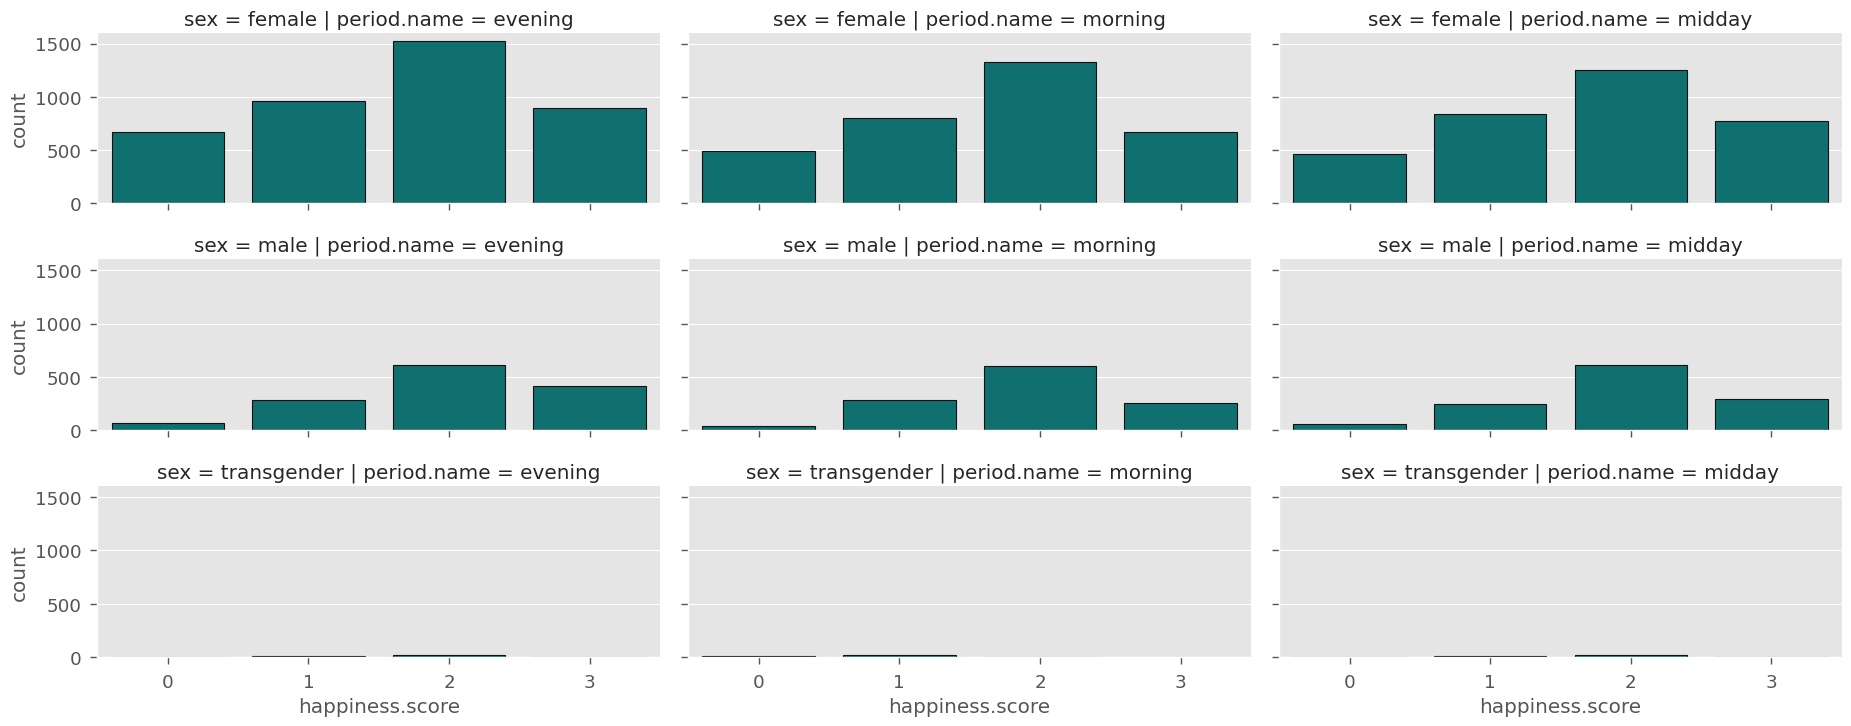

<Figure size 800x550 with 0 Axes>

In [73]:
g = sns.FacetGrid(data = df, col= 'period.name', row = 'sex', height = 2.5, 
                  aspect = 2.5)

g.map_dataframe(sns.countplot, 'happiness.score', color = 'teal', 
                edgecolor = 'k')

plt.tight_layout()
plt.show()
plt.savefig('testplot6.png')

Before proceeding with the analysis of the graph above, see that:

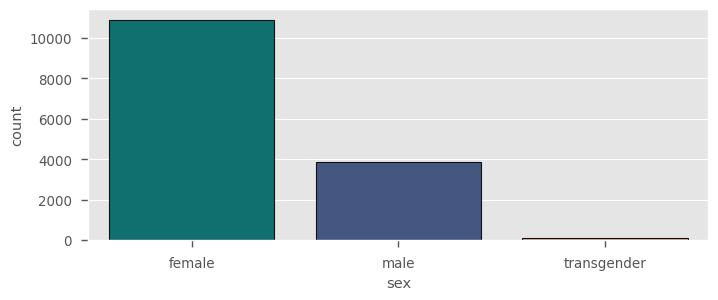

<Figure size 800x550 with 0 Axes>

In [74]:
sns.set_context(context = 'paper', font_scale= 1.1)

plt.figure(figsize = (8,3))
sns.countplot(x = 'sex', data = df, 
              palette=['teal','#3b528b', 'darksalmon'],
              edgecolor = 'k')

plt.show()
plt.savefig('testplot7.png')

Note that the complete dataset (considering that the same individual took the test multiple times) has more women with a smaller number of transgender individuals, which explains the discrepancy between the distributions shown in the `happiness.score` graphs for `sex` and `period.name`. It is important to note that the distributions seem to be similar regardless of both categorical factors, with `happiness.score` around 2.

Before we start a general change in the original dataframe, let's see, from the raw data, the correlations of the data with the happiness score:

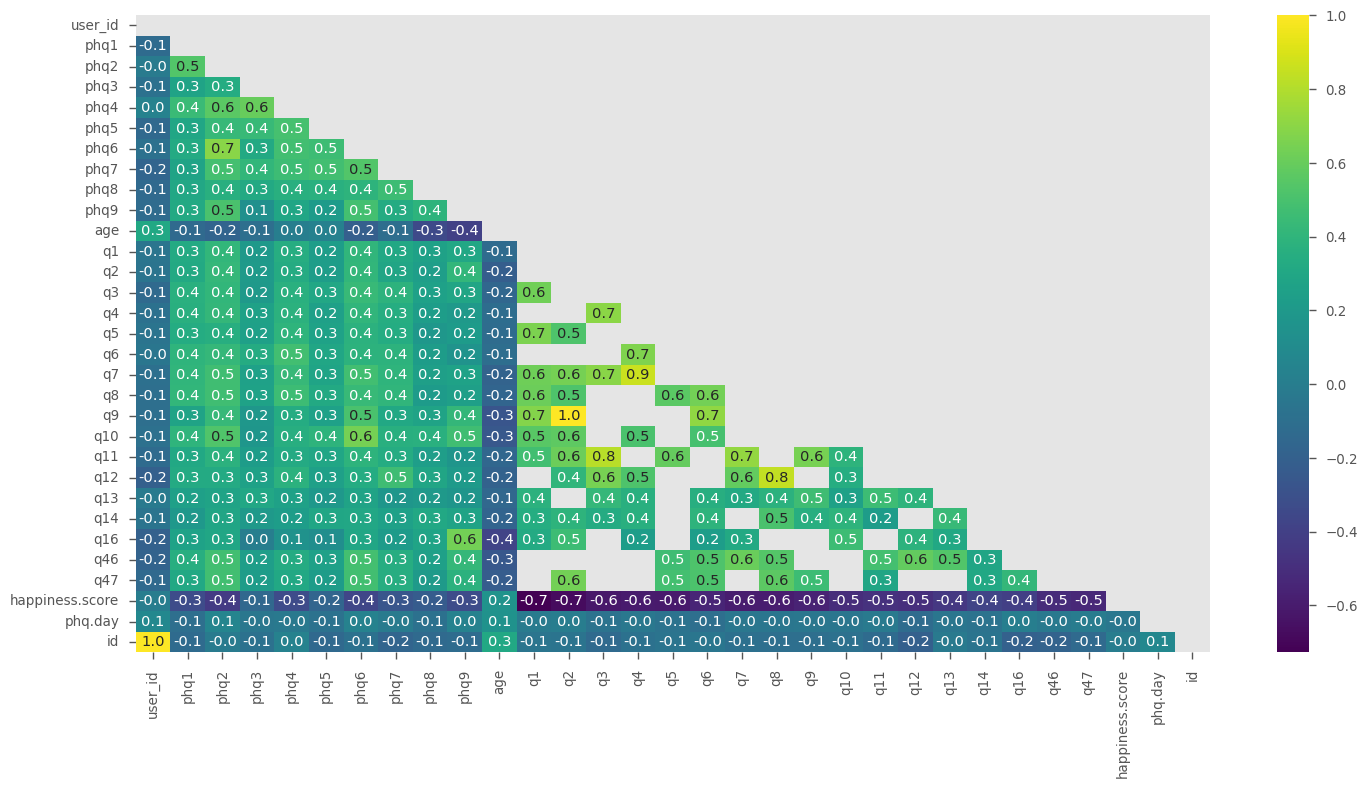

<Figure size 800x550 with 0 Axes>

In [75]:
plt.figure(figsize=(15, 8))

mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(df.corr(), cmap = 'viridis', mask = mask,
            annot = True, fmt='.1f')

plt.tight_layout()
plt.show()
plt.savefig('testplot8.png')

Notice that apparently the AA responses have an almost perfect negative correlation with happiness score, while age is the only attribute that is positively correlated (but at the same time it is a weak correlation).

Let's prepare our data to apply to the model.

# Dealing with categorical attributes and data cleaning

First let's see how long the patients were hospitalized (or taking the test) and we'll put it as a column:

In [76]:
df['total.period'] = (df['time'] - df['start.time']).dt.days

Now we can drop some unnecessary columns:

In [77]:
df = df.drop(columns = ['time', 'start.time', 'user_id', 'period.name', 'phq.day'])

The column `user_id` was also dropped as it is the same column as `id`. In addition, the column `period.name` was dropped because we saw in EDA that the time of day the test was taken did not have a significant influence on the distribution of data (for each sex!) for `happiness.score`. Now we need to deal with the `sex` column.

In this case, `LabelEncoder` was initially considered:

    LE=LabelEncoder()

    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    for i in object_cols:
        df[i]=df[[i]].apply(LE.fit_transform)

However, in one of our discussions we observed that this case considers a hierarchical case (0 to 4) which would not make sense for the sex column. What we will do is use `get_dummies`:

In [78]:
# First let's consider that people who didn't want to identify themselves will have the 'category' unknown
df['sex'].fillna('unknown', inplace=True)

df = pd.get_dummies(df, columns=['sex'], dtype=np.int64)

In [79]:
df.head()

,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,age,...,q16,q46,q47,happiness.score,id,total.period,sex_female,sex_male,sex_transgender,sex_unknown
1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,2,1,13,0,0,0,1
2,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,3,1,30,0,0,0,1
3,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,3,1,30,0,0,0,1
4,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,1.0,NaN,NaN,2,1,13,0,0,0,1
5,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,2,1,12,0,0,0,1


Let's see what happens when we do this and see how many people are part of the transgender and undeclared gender groups:

In [80]:
df[df['sex_transgender'] == 1]['id'].unique()

array([178])

In [81]:
df[df['sex_unknown'] == 1]['id'].unique()

array([  1,  10,  15,  19,  20,  35,  45,  48,  56,  63,  75,  78,  80,
        98, 106, 111, 115, 118, 119, 131, 146, 150, 151, 152])

We ended up with a case where there is only one transgender person who took the test, therefore, we will drop this patient.

In [82]:
df = df[df['sex_transgender'] == 0]
df = df.drop('sex_transgender', axis=1)

In [83]:
df.head()

,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,age,...,q14,q16,q46,q47,happiness.score,id,total.period,sex_female,sex_male,sex_unknown
1,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,0.0,NaN,NaN,NaN,2,1,13,0,0,1
2,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,1.0,NaN,3,1,30,0,0,1
3,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,3,1,30,0,0,1
4,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,NaN,1.0,NaN,NaN,2,1,13,0,0,1
5,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,NaN,...,1.0,NaN,1.0,NaN,2,1,12,0,0,1


Now we will do the following, the important aspect of phq scores to assess the level of depression is the SUM of these scores, therefore:

In [84]:
df['depression_severity'] = df[['phq1', 'phq2', 'phq3','phq4', 'phq5', 'phq6','phq7', 'phq8', 'phq9']].sum(axis=1)

Since we have what we need, let's drop these columns:

In [85]:
df = df.drop(columns = ['phq1', 'phq2', 'phq3','phq4', 'phq5', 'phq6','phq7', 'phq8', 'phq9'])

Since the AA scores have a lot of missing data, let's drop those too:

In [86]:
df = df.drop(columns = ['q1', 'q2', 'q3','q4', 'q5', 'q6','q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q16', 'q46', 'q47'])

In [87]:
df.isnull().sum()

age                    6456
happiness.score           0
id                        0
total.period              0
sex_female                0
sex_male                  0
sex_unknown               0
depression_severity       0
dtype: int64

The issue lies with the age column. Three options have been considered:

- Filling with mean or median value;
- Training a regression model to predict the age;
- Dropping the column altogether.

Let's take the third way and drop:

In [88]:
df = df[~df['age'].isnull()]

So, let's see how the group of people who didn't want to identify themselves turned out:

In [89]:
df[df['sex_unknown'] == 1]['id'].unique()

array([131])

Only one person! Drop!

In [90]:
df = df[df['sex_unknown'] == 0]
df = df.drop('sex_unknown', axis=1)

This dataframe is free of missing values! Now let's take a look at the heatmap and see the final correlation.

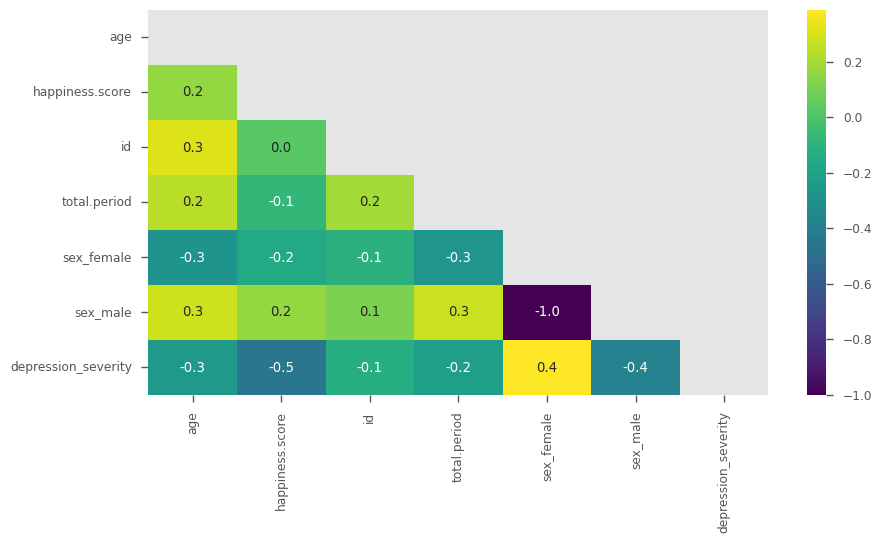

<Figure size 800x550 with 0 Axes>

In [91]:
sns.set_context(context = 'paper', font_scale= 1)

plt.figure(figsize=(10, 5))

mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(df.corr(), cmap = 'viridis', mask = mask,
            annot = True, fmt='.1f')

plt.show()
plt.savefig('testplot9.png')

At this point, we can take two approaches:

- By patient: Listing the characteristics of patients who are more prone to depressive disorders.
- By sample: Analyzing how patient groups respond to clinical measures.

Therefore, we will create two dataframes, one grouped by ID (median) and the other not grouped.

In [92]:
df_id = df.groupby('id').median()
df_id.head()

,age,happiness.score,total.period,sex_female,sex_male,depression_severity
id,,,,,,
3,22.0,2.0,6.5,1.0,0.0,8.0
4,17.0,2.0,56.5,1.0,0.0,17.0
6,24.0,2.0,68.5,1.0,0.0,18.0
7,16.0,0.0,23.0,1.0,0.0,23.0
8,26.0,2.0,12.0,1.0,0.0,10.0


In [93]:
df = df.drop('id', axis = 1)
df.head()

,age,happiness.score,total.period,sex_female,sex_male,depression_severity
477,22.0,2,9,1,0,8.0
478,22.0,2,0,1,0,8.0
479,22.0,2,12,1,0,8.0
480,22.0,2,10,1,0,8.0
481,22.0,2,9,1,0,8.0


In [94]:
print('Shape df by id:', df_id.shape)
print('Shape df without id:', df.shape)

Shape df by id: (109, 6)
Shape df without id: (9552, 6)


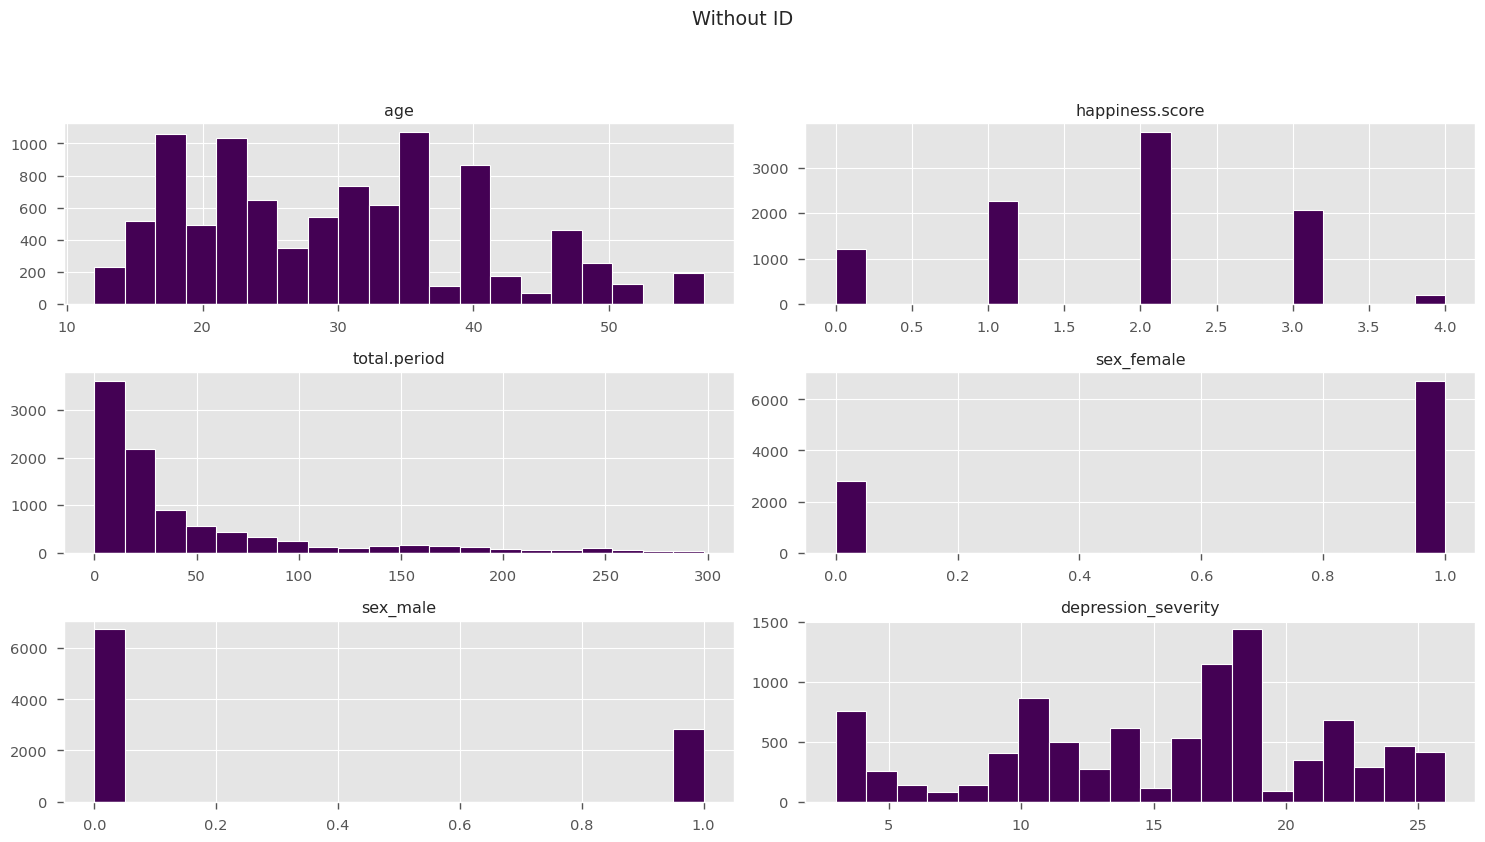

<Figure size 800x550 with 0 Axes>

In [95]:
sns.set_context(context = 'paper', font_scale= 1.2)

df.hist(figsize = (15,8), color = '#440154', edgecolor = 'white', bins = 20)

plt.suptitle('Without ID', y = 1.05)

plt.tight_layout()
plt.show()
plt.savefig('testplot10.png')

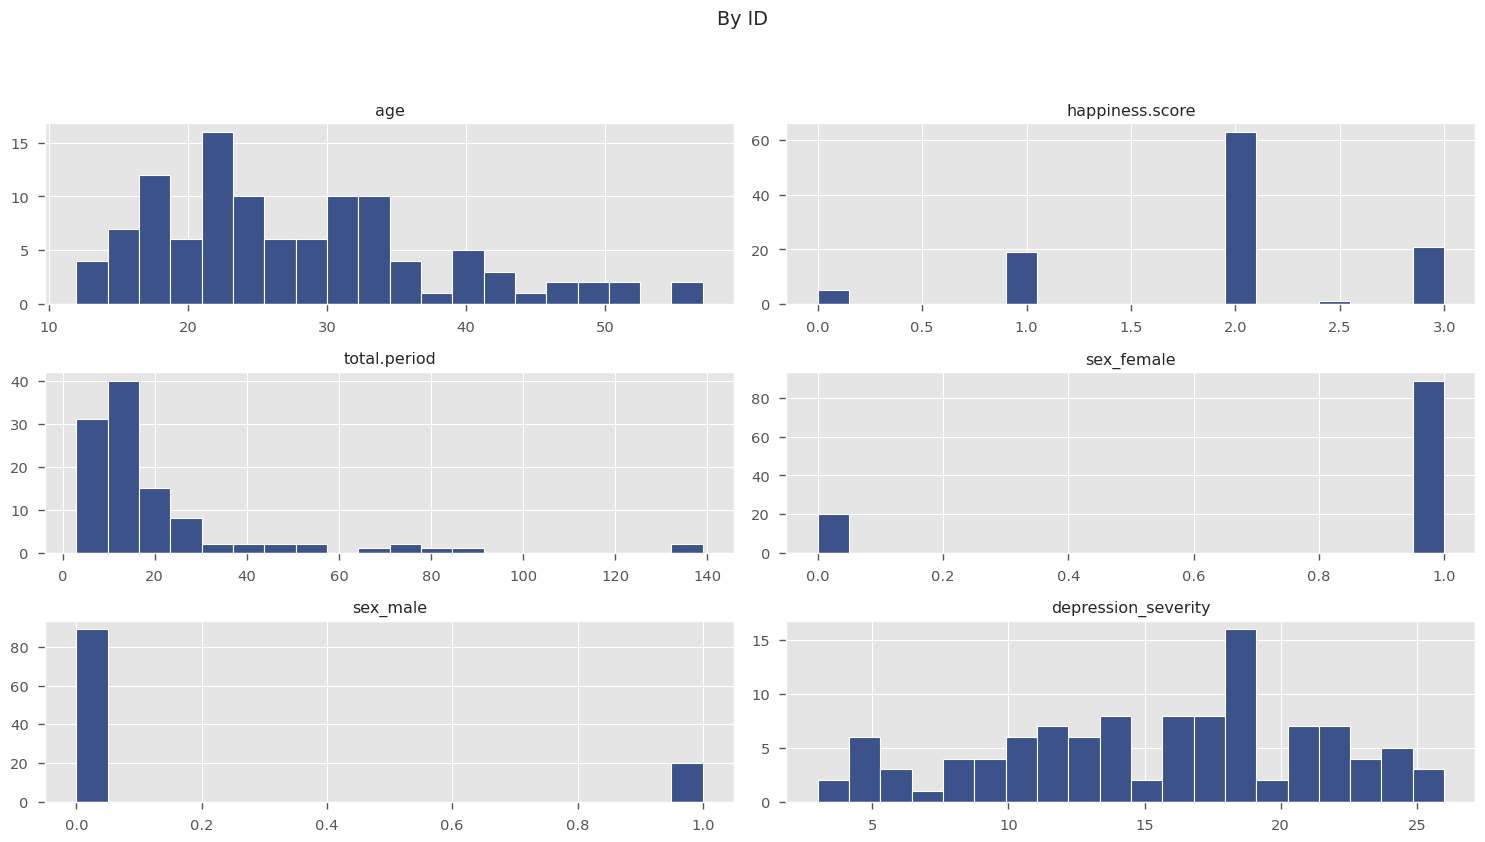

<Figure size 800x550 with 0 Axes>

In [96]:
df_id.hist(figsize = (15,8), color = '#3b528b', edgecolor = 'white', bins = 20)

plt.suptitle('By ID', y = 1.05)

plt.tight_layout()
plt.show()
plt.savefig('testplot11.png')

When analyzing a dataset, we can approach it from different perspectives, such as by individual or by group. In the case of studying depression, for example, we can create a dataframe grouped by each patient, where we list the characteristics of those more prone to depressive states, or we can analyze the way in which groups of patients respond to clinical measures by creating an ungrouped dataframe.

In our analysis, we created both dataframes and compared them. However, when we plotted the distributions for each feature, we noticed that they were quite similar between the two approaches. In order to preserve the completeness of the sample, we will consider the approach by sample, as it still provides valuable insights into how different groups of patients respond to the clinical measures.

# Data pre-processing

## Features normalization

`StandardScaler` is a technique used to normalize the features (variables) of a dataset so that they have a mean of zero and standard deviation of one.

This normalization is important because many algorithms are sensitive to the scale of the features and if the features are on different scales, it can negatively impact the performance of the model. For example,

In [97]:
df.describe()

,age,happiness.score,total.period,sex_female,sex_male,depression_severity
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,29.766122,1.770519,46.278685,0.704774,0.295226,15.360134
std,10.592496,0.996958,60.340815,0.456168,0.456168,6.042421
min,12.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,21.000000,1.000000,9.000000,0.000000,0.000000,11.000000
50%,29.000000,2.000000,21.000000,1.000000,0.000000,17.000000
75%,36.000000,2.000000,56.000000,1.000000,1.000000,19.000000
max,57.000000,4.000000,298.000000,1.000000,1.000000,26.000000


our data has values ranging from 0 to 4 for the `happiness.score` column, while in the `total.period` column it ranges from 0 to 298 as shown in the previous `df.describe`. As a result, the feature with the larger scale may dominate the contribution to the model and hide the importance of the other feature. Normalizing the features with StandardScaler helps to avoid this problem.

In [98]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)

In [99]:
scaled_df.head()

,age,happiness.score,total.period,sex_female,sex_male,depression_severity
0,-0.73321,0.230193,-0.617834,0.647221,-0.647221,-1.218141
1,-0.73321,0.230193,-0.766995,0.647221,-0.647221,-1.218141
2,-0.73321,0.230193,-0.568114,0.647221,-0.647221,-1.218141
3,-0.73321,0.230193,-0.601261,0.647221,-0.647221,-1.218141
4,-0.73321,0.230193,-0.617834,0.647221,-0.647221,-1.218141


# Finding the optimal number of clusters

The Elbow method is a technique used to determine the ideal number of clusters in a clustering analysis. The method is based on plotting a graph of the values of the sum of the intra-cluster squared distances against the number of clusters, and identifying the "elbow point", where the curve flattens out. The "elbow point" represents the ideal number of clusters to be used in the analysis.

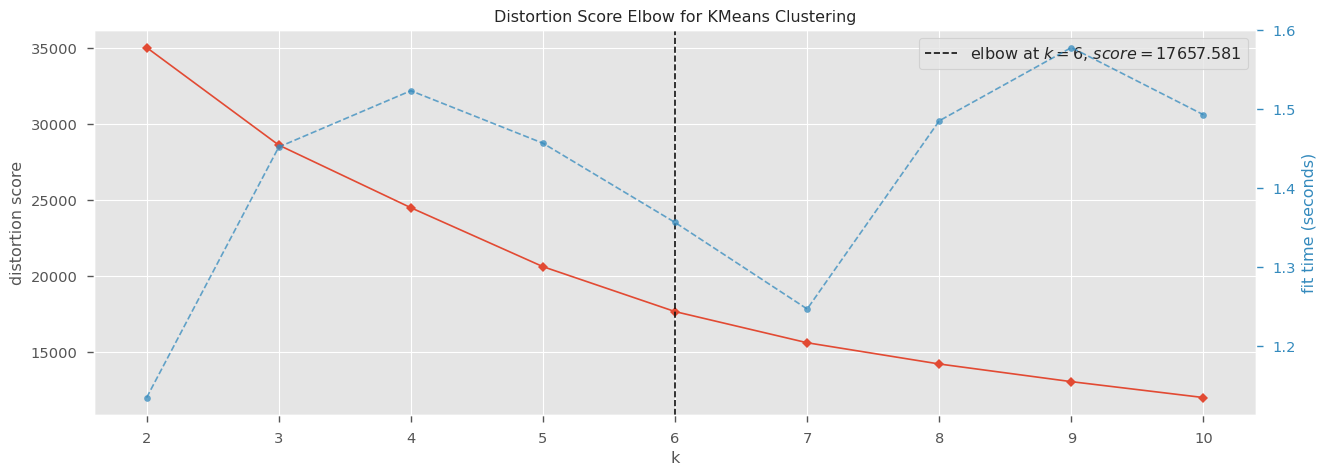

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [100]:
plt.figure(figsize=(15, 5))

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled_df)
Elbow_M.show()

plt.tight_layout()
plt.show()
plt.savefig('testplot12.png')

The figure above shows that $k = 6$ would actually be an ideal number of clusters for this data. But, let's see the silhouette:

In [101]:
kmeans = KMeans(n_clusters = 5)

kmeans.fit_predict(scaled_df)

score = silhouette_score(scaled_df, kmeans.labels_, metric='euclidean')
print('Silhouetter Average Score: %.3f' % score)

Silhouetter Average Score: 0.304


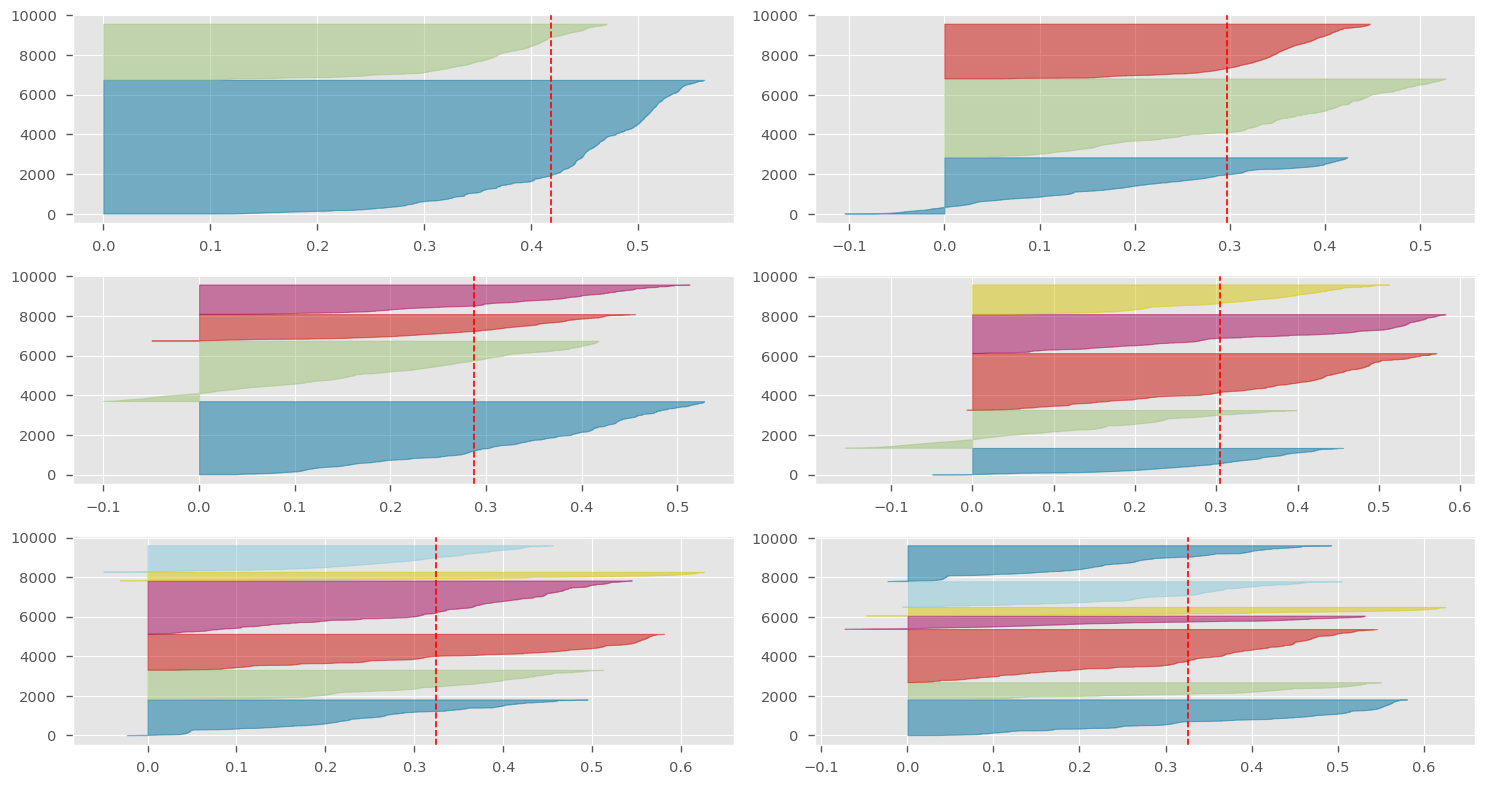

<Figure size 800x550 with 0 Axes>

In [102]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))

for i in range(2,8):
    kmeans = KMeans(n_clusters = i, 
                    init='k-means++', 
                    n_init = 10, 
                    max_iter = 100, 
                    random_state = 42)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(kmeans, 
                                      colors='yellowbrick', 
                                      ax=ax[q-1][mod])
    visualizer.fit(scaled_df)

plt.tight_layout()
plt.show()
plt.savefig('testplot13.png')

The Silhouette Average Score is a metric used to evaluate the quality of clustering in a dataset. The metric measures how well each object (or sample) in a cluster resembles the objects in the same cluster compared to objects in other clusters.

The silhouette score can range from -1 to 1. A coefficient close to +1 means that the instance is well within its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to the boundary of a cluster; finally, a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In this specific case, the value is reasonably close to 0 (Silhouetter Average Score: 0.304 for k = 5), which means that the clusters are close to each other.

An even more informative visualization is obtained when we plot the silhouette coefficient of each instance, classified by the clusters they are assigned to and by the coefficient value. This is called a **silhouette plot** (which we did earlier). Each plot contains a knife shape for each cluster. The height of the shape indicates the number of instances in the cluster, and its width represents the sorted silhouette coefficients of the instances in the cluster (the wider, the better).

The vertical dashed lines represent the average silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than that score (i.e., if many of the instances stop before the dashed line, ending to its left), the cluster is quite bad, as this means that its instances are too close to other clusters. Note that in this case, with k = 5, the clusters seem very good, as most instances extend beyond the dashed line to the right and closer to 1.0, and the densities of each cluster are more uniform than in the case of k = 6.

In [103]:
kmeans = KMeans(n_clusters = 5)

yhat = kmeans.fit_predict(scaled_df)

# Adding the Clusters to the original dataframe
df["Clusters"] = yhat

In [104]:
df.head()

,age,happiness.score,total.period,sex_female,sex_male,depression_severity,Clusters
477,22.0,2,9,1,0,8.0,4
478,22.0,2,0,1,0,8.0,4
479,22.0,2,12,1,0,8.0,4
480,22.0,2,10,1,0,8.0,4
481,22.0,2,9,1,0,8.0,4


# Cluster Analysis

Since this is an unsupervised clustering, we do not have a marked target to evaluate or score our model. The goal here is to study the patterns in the formed clusters and determine their nature.

To do this, we will take a look at the data in the light of the clusters through exploratory data analysis and draw conclusions.

In [105]:
palette = {'color': ['#440154', '#bc3754', '#21918c', '#a0da39', '#fde725'],
           'Clusters': [0, 1, 2, 3, 4]}

palette['color']

['#440154', '#bc3754', '#21918c', '#a0da39', '#fde725']

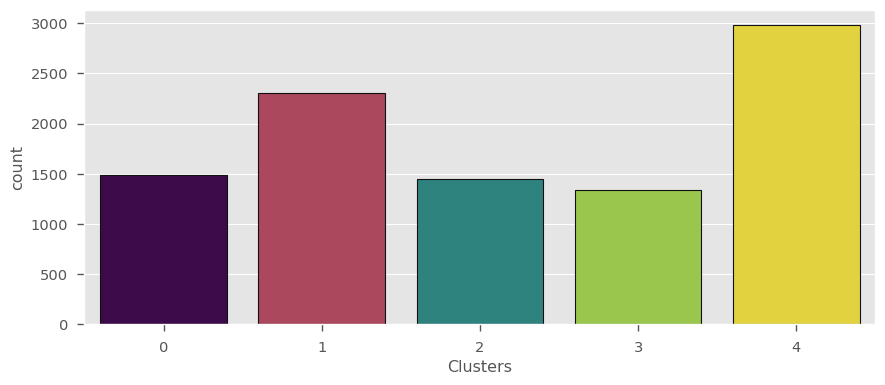

<Figure size 800x550 with 0 Axes>

In [106]:
plt.figure(figsize = (9,4))

sns.countplot(x=df['Clusters'], edgecolor = 'k', palette = palette['color'])

plt.tight_layout()
plt.show()
plt.savefig('testplot14.png')

Clusters appear to be fairly distributed.

In [107]:
df_fem = df[df['sex_female'] == 1]
df_mal = df[df['sex_male'] == 1]

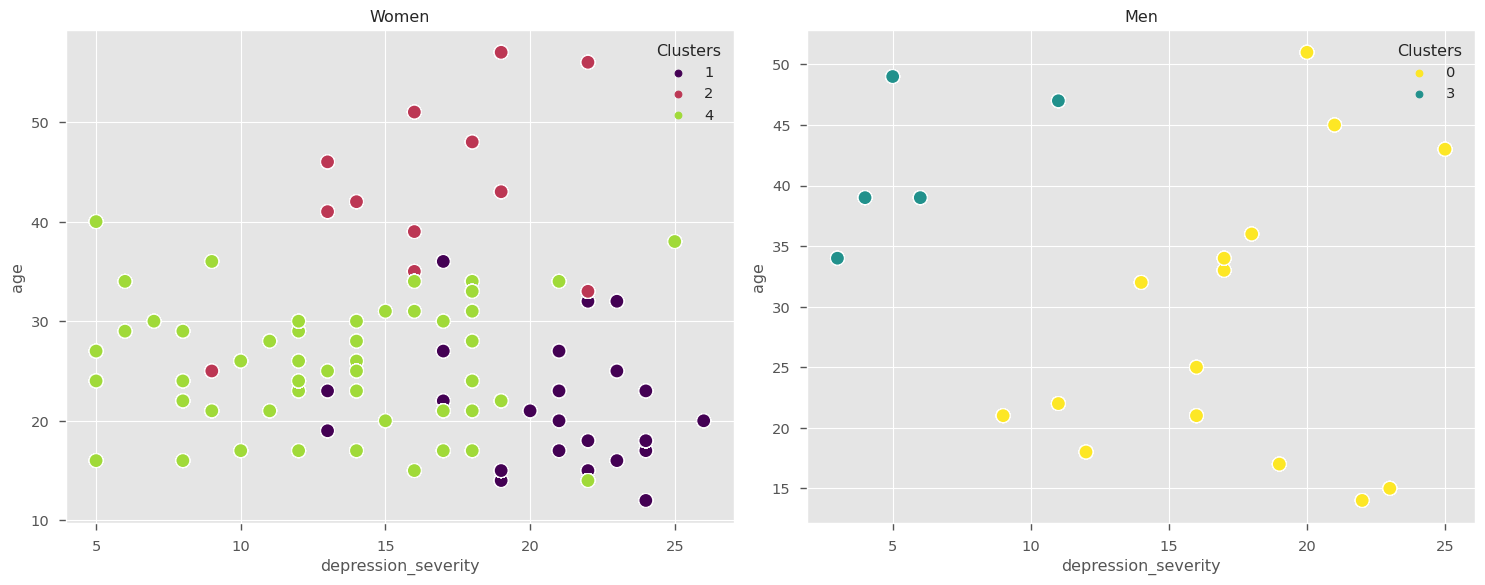

<Figure size 800x550 with 0 Axes>

In [108]:
plt.figure(figsize = (15,6))

ax = plt.subplot(1,2,1)
sns.scatterplot(data = df_fem, x = 'depression_severity', y = 'age', hue = 'Clusters',
                palette = ['#440154', '#bc3754', '#a0da39'],
                ax = ax, s = 100)
plt.title('Women')

ax = plt.subplot(1,2,2)
sns.scatterplot(data = df_mal, x = 'depression_severity', y = 'age', hue = 'Clusters',
                palette = ['#fde725', '#21918c'],
                ax = ax, s = 100)
plt.title('Men')

plt.tight_layout()
plt.show()
plt.savefig('testplot14.png')

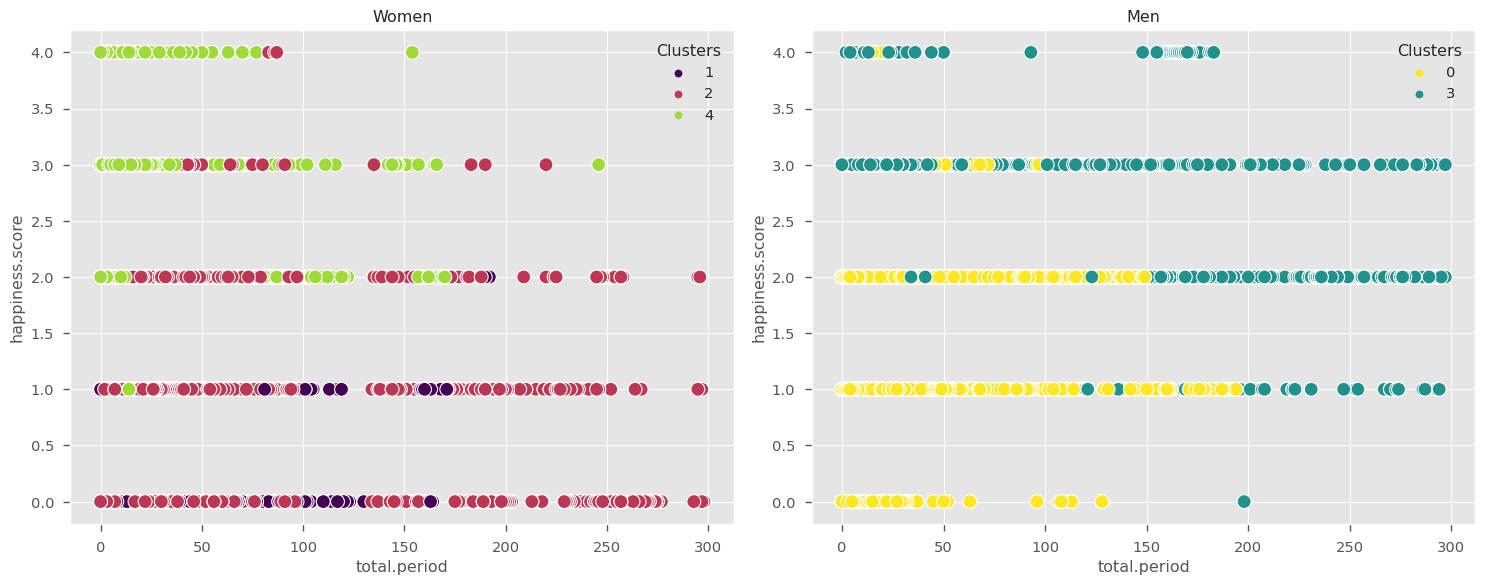

<Figure size 800x550 with 0 Axes>

In [109]:
plt.figure(figsize = (15,6))

ax = plt.subplot(1,2,1)
sns.scatterplot(data = df_fem, x = 'total.period', y = 'happiness.score', hue = 'Clusters',
                palette = ['#440154', '#bc3754', '#a0da39'],
                ax = ax, s = 100)
plt.title('Women')

ax = plt.subplot(1,2,2)
sns.scatterplot(data = df_mal, x = 'total.period', y = 'happiness.score', hue = 'Clusters',
                palette = ['#fde725', '#21918c'],
                ax = ax, s = 100)
plt.title('Men')

plt.tight_layout()
plt.show()
plt.savefig('testplot15.png')

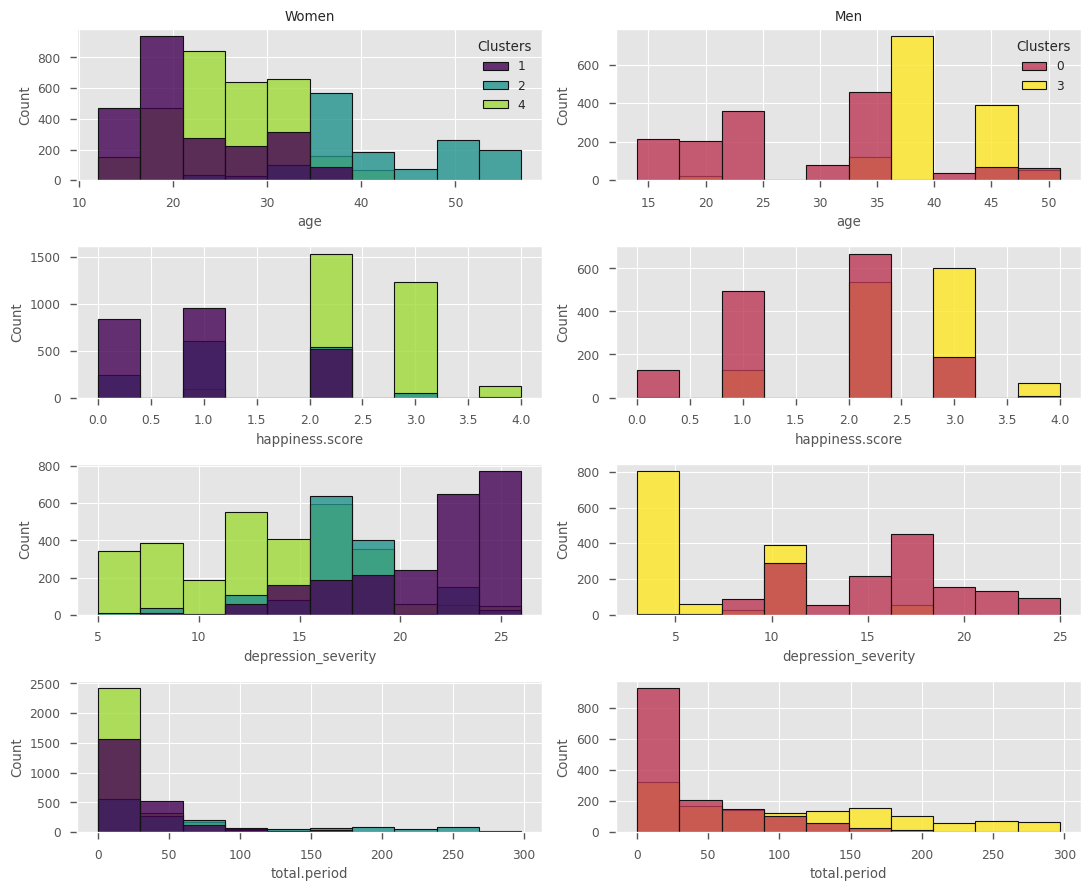

<Figure size 800x550 with 0 Axes>

In [110]:
sns.set_context(context = 'paper', font_scale= 1)
plt.figure(figsize = (11,9))

ax = plt.subplot(4,2,1)
sns.histplot(x = 'age', data = df_fem, hue = 'Clusters', 
             palette = ['#440154', '#21918c', '#a0da39'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax)

plt.title('Women')

ax = plt.subplot(4,2,2)
sns.histplot(x = 'age', data = df_mal, hue = 'Clusters', 
             palette = ['#bc3754', '#fde725'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax)

plt.title('Men')

ax = plt.subplot(4,2,3)
sns.histplot(x = 'happiness.score', data = df_fem, hue = 'Clusters', 
             palette = ['#440154', '#21918c', '#a0da39'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,4)
sns.histplot(x = 'happiness.score', data = df_mal, hue = 'Clusters', 
             palette = ['#bc3754', '#fde725'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,5)
sns.histplot(x = 'depression_severity', data = df_fem, hue = 'Clusters', 
            palette = ['#440154', '#21918c', '#a0da39'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,6)
sns.histplot(x = 'depression_severity', data = df_mal, hue = 'Clusters', 
             palette = ['#bc3754', '#fde725'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,7)
sns.histplot(x = 'total.period', data = df_fem, hue = 'Clusters', 
             palette = ['#440154', '#21918c', '#a0da39'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)

ax = plt.subplot(4,2,8)
sns.histplot(x = 'total.period', data = df_mal, hue = 'Clusters', 
             palette = ['#bc3754', '#fde725'], 
             bins = 10, alpha = 0.8, edgecolor = 'k', ax = ax,
            legend = False)


plt.tight_layout()
plt.show()
plt.savefig('testplot16.png')

--- 
From the analysis of the above graphs, we can see that:

- **Cluster 0**: Mostly men under 35 years old who suffer from moderate/severe depression.

- **Cluster 1**: Young women who suffer from moderate/severe depression.

- **Cluster 2**: Elderly women who suffer from moderate/severe depression.

- **Cluster 3**: Elderly men who have either mild or no depression symptoms.

- **Cluster 4**: Young women who suffer from mild/moderate depression.

---

Based on the provided cluster analysis of depression levels using PHQ-9, the following clusters should be considered for clinical analysis and medical follow-up: Cluster 0, 1 and 2. These clusters have higher levels of depression severity and may require further medical attention and treatment. It is important to note that cluster analysis is just one tool in the assessment of depression and a more comprehensive evaluation is required for individualized treatment plans.

In [111]:
df.head()

,age,happiness.score,total.period,sex_female,sex_male,depression_severity,Clusters
477,22.0,2,9,1,0,8.0,4
478,22.0,2,0,1,0,8.0,4
479,22.0,2,12,1,0,8.0,4
480,22.0,2,10,1,0,8.0,4
481,22.0,2,9,1,0,8.0,4


In [112]:
df.shape

(9552, 7)

In [113]:
features = df[['age', 'total.period', 'sex_female', 'sex_male', 'depression_severity']]
target = df['happiness.score']

In [114]:
features.head()

,age,total.period,sex_female,sex_male,depression_severity
477,22.0,9,1,0,8.0
478,22.0,0,1,0,8.0
479,22.0,12,1,0,8.0
480,22.0,10,1,0,8.0
481,22.0,9,1,0,8.0


In [115]:
target.head()

477    2
478    2
479    2
480    2
481    2
Name: happiness.score, dtype: int64

In [116]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [117]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

In [118]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

In [119]:
# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

In [120]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.5480818024962353


In [121]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 0.5248705287096183
R-squared (R2): 0.4578503515136315


In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)